In [ ]:
!pip install category_encoders
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression,RidgeCV,LassoCV,ElasticNetCV,LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce
import warnings
import gdown

## **Cargado de datos**

**Este set de datos contiene alrededor de 10 años de observaciones meteorológicas diarias en diferentes localizaciones de Australia.**

**El objetivo es la predicción de las columnas 'RainTomorrow' y 'RainfallTomorrow' en función del resto de las características que se consideren adecuadas.**

In [2]:
# LINK DEL DATASET
url = 'https://drive.google.com/drive/folders/1B8mJ5JZo_x-p7zCKY3ur_xVgFn8M_amY?usp=drive_link'

# DESCARGAR Y GUARDAR EN EL ENTORNO
gdown.download_folder(url, quiet=True, output='DATASET')

#uploaded = files.upload()

['DATASET/weatherAUS.csv']

In [5]:
datos = pd.read_csv('/content/DATASET/weatherAUS.csv')
datos.head(1)

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
0,0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,0.0


## **Exploración de los datos**

In [6]:
# SELECCIONAR LAS CIUDADES DE INTERES
ciudades = ['Adelaide', 'Canberra', 'Cobar', 'Dartmoor' , 'Melbourne',
            'MelbourneAirport', 'MountGambier', 'Sydney', 'SydneyAirport']
datos.query('Location.isin(@ciudades)',inplace=True)

# ELIMINO LA COLUMNA 0 Y RESETEO EL INDICE DE PD
datos.drop(datos.columns[0], axis=1, inplace=True)
datos.reset_index(drop=True, inplace=True)

**Para el objetivo de las predicciones solo nos quedamos con los registros para nueve localizaciones.**

In [ ]:
# TAMAÑO DEL ARCHIVO
print(f'Tamaño del dataset:\n{datos.shape[0]} filas - {datos.shape[1]} columnas')

Tamaño del dataset:
28233 filas - 24 columnas


In [ ]:
# INFORMACIÓN DEL DATASET
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28233 entries, 0 to 28232
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              28233 non-null  object 
 1   Location          28233 non-null  object 
 2   MinTemp           27663 non-null  float64
 3   MaxTemp           27675 non-null  float64
 4   Rainfall          27247 non-null  float64
 5   Evaporation       23880 non-null  float64
 6   Sunshine          21520 non-null  float64
 7   WindGustDir       26588 non-null  object 
 8   WindGustSpeed     26591 non-null  float64
 9   WindDir9am        26585 non-null  object 
 10  WindDir3pm        27796 non-null  object 
 11  WindSpeed9am      27875 non-null  float64
 12  WindSpeed3pm      27893 non-null  float64
 13  Humidity9am       27293 non-null  float64
 14  Humidity3pm       27343 non-null  float64
 15  Pressure9am       27394 non-null  float64
 16  Pressure3pm       27404 non-null  float6

**El set de datos contiene una combinación de variables categóricas y numéricas.**

*   **Las variables categóricas tienen tipo de datos object.**

*   **Las variables numéricas tienen tipo de datos float64.**

*   **Además, hay presencia de valores faltantes en el conjunto de datos.**


In [ ]:
# VALORES FALTANTES EN EL DATASET
datos.isnull().sum()

Date                   0
Location               0
MinTemp              570
MaxTemp              558
Rainfall             986
Evaporation         4353
Sunshine            6713
WindGustDir         1645
WindGustSpeed       1642
WindDir9am          1648
WindDir3pm           437
WindSpeed9am         358
WindSpeed3pm         340
Humidity9am          940
Humidity3pm          890
Pressure9am          839
Pressure3pm          829
Cloud9am            9367
Cloud3pm            9550
Temp9am              585
Temp3pm              576
RainToday            986
RainTomorrow         985
RainfallTomorrow     985
dtype: int64

**El dataset contiene 24 características relevantes con información climática:**

*   Date: fecha de la observación.
*   Location: nombre de las ubicaciones.
*   MinTemp y MaxTemp: valores max. y min. de temperaturas en °C.
*   Rainfall: milímetros de lluvia en el día.
*   Evaportion: mm de evaporación diarias.
*   Sunshine: horas de sol durante el día.
*   WindGustDir: direcciones de las rafagas de viento.
*   WindGustSpeed: velocidad en km/h de las rafagas de viento diarias.
*   WindDir9am/WindDir3pm: direcciones del viento a las 9am y 3pm.
*   WindSpeed9am/WindSpeed3pm: velocidad del viento a las 9am y 3pm.
*   Humidity9am/Humidity3pm: porcentaje de humedad a las 9am y 3pm.
*   Pressure9am/Pressure3pm: presión atmosférica en hpa a las 9am y 3pm.
*   Cloud9am/Cloud3pm: nivel de nubosidad en octales a las 9am y 3pm.
*   Temp9am/Temp3pm: temperatura en °C a las 9am y 3pm.
*   RainToday: booleano 1 si la precipitación supera los 1mm (0 contrario).
*   RainTomorrow: cantidad de lluvia al día siguiente en mm.
*   RainfallTomorrow: booleano 1 si llovio al día siguiente (0 contrario).


In [ ]:
# ANÁLISIS DESCRIPTIVO DE LAS VARIABLES NUMÉRICAS
datos.describe().round(1)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainfallTomorrow
count,27663.0,27675.0,27247.0,23880.0,21520.0,26591.0,27875.0,27893.0,27293.0,27343.0,27394.0,27404.0,18866.0,18683.0,27648.0,27657.0,27248.0
mean,11.3,21.9,2.1,4.8,6.9,41.8,15.1,20.0,68.8,50.5,1018.2,1016.1,4.7,4.7,15.5,20.4,2.0
std,5.7,6.7,6.4,3.7,3.9,14.2,9.5,9.0,18.7,19.9,7.4,7.3,2.8,2.6,5.7,6.5,6.4
min,-8.0,4.1,0.0,0.0,0.0,9.0,0.0,0.0,5.0,1.0,982.3,984.9,0.0,0.0,-1.3,3.7,0.0
25%,7.4,16.6,0.0,2.2,3.8,31.0,9.0,13.0,57.0,37.0,1013.3,1011.3,1.0,2.0,11.4,15.4,0.0
50%,10.9,21.0,0.0,4.0,7.4,39.0,13.0,19.0,70.0,50.0,1018.4,1016.3,6.0,6.0,15.0,19.5,0.0
75%,15.2,26.2,1.0,6.6,10.0,50.0,20.0,26.0,83.0,64.0,1023.3,1021.1,7.0,7.0,19.1,24.5,1.0
max,33.9,46.8,119.4,86.2,14.3,122.0,69.0,76.0,100.0,100.0,1040.6,1037.9,9.0,8.0,38.6,46.1,119.4


## **Visualización**

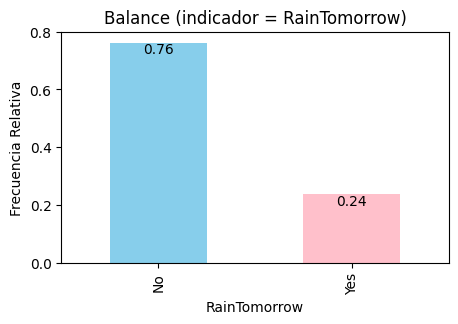

In [ ]:
# GRÁFICO PARA VISUALIZAR EL BALANCE DE 'RainTomorrow'
frecuencia_relativa = datos['RainTomorrow'].value_counts(normalize=True)

plt.figure(figsize=(5, 3))
grafico = frecuencia_relativa.plot(kind='bar', color=['skyblue', 'pink'])

plt.title('Balance (indicador = RainTomorrow)')
plt.xlabel('RainTomorrow')
plt.ylabel('Frecuencia Relativa')

for index, value in enumerate(frecuencia_relativa):
    plt.text(index, value, f'{value:.2f}', ha='center', va='top')

plt.show()

**Se observa que existe un desbalance de los datos en un 76/24, con la etiqueta 'NO' como clase mayoritaria.**

*   **El NO tiene un total de 20777 entradas**

*   **El SI tiene un total de 6471 entradas**


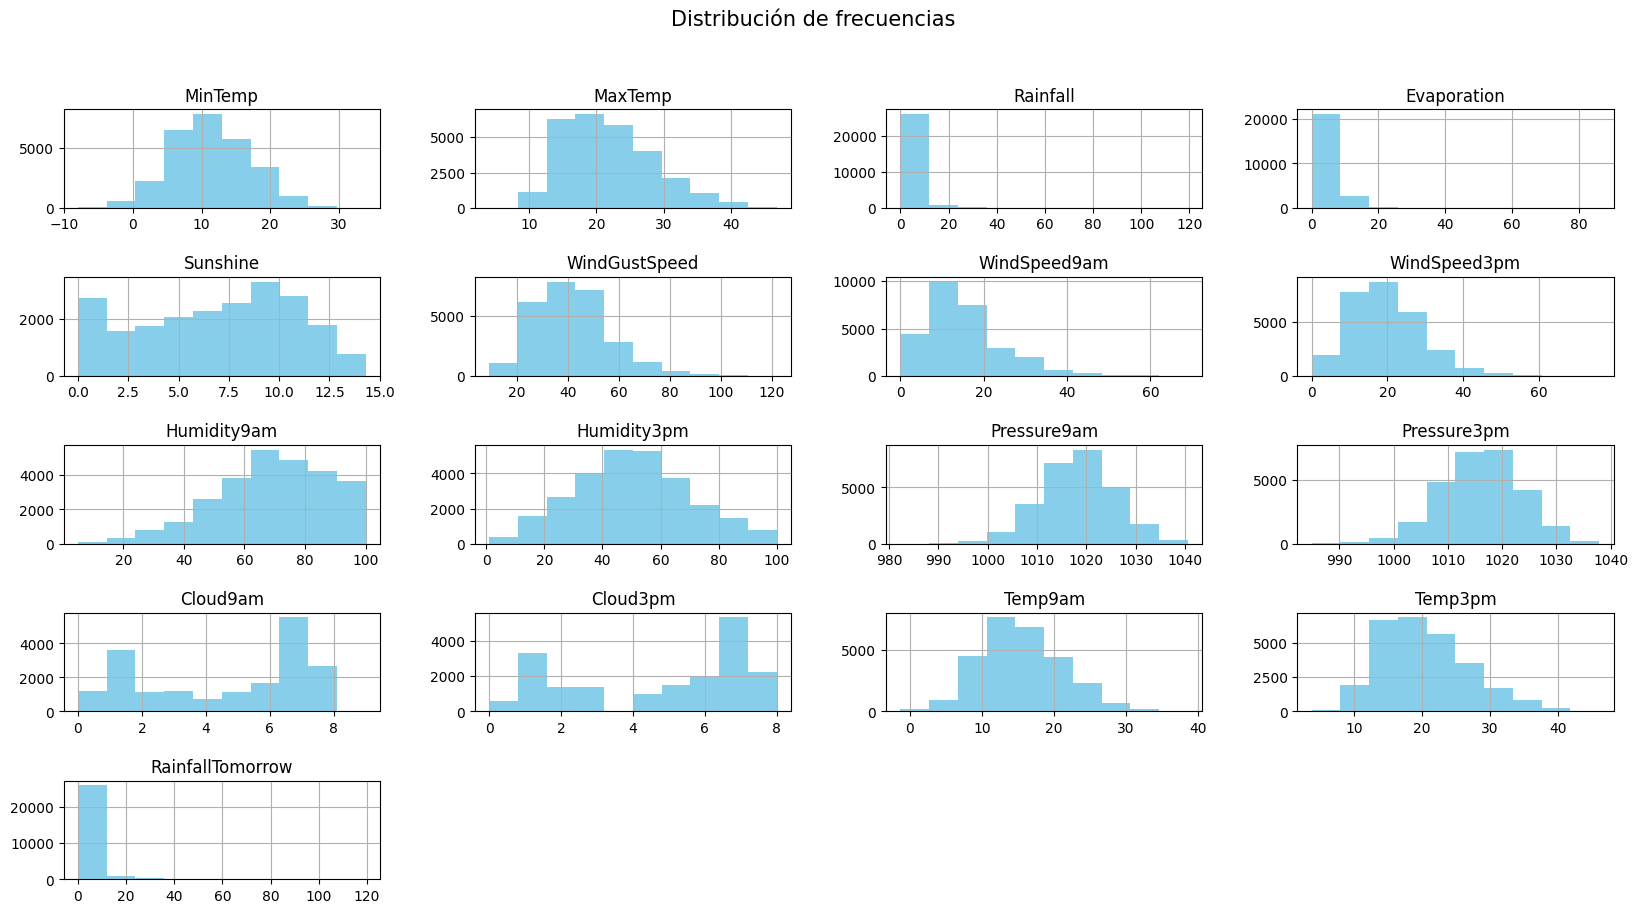

In [ ]:
# HISTOGRAMA DE LOS ATRIBUTOS
datos.hist(figsize=(20,10), facecolor='skyblue')
plt.subplots_adjust(hspace=0.7)
plt.suptitle('Distribución de frecuencias', fontsize=15)
plt.show()

In [5]:
def box_plot(dataset, inf_lim = 0, sup_lim = 0):
  """
  Función para generar boxplots en una misma figura (max. 8).
  Parámetros:
  - dataset: Ruta del set de datos.
  - inf_lim: Limite inferior del slicing.
  - sup_lim: Limite superior del slicing.
  """
  plt.figure(figsize=(16, 8), facecolor='lavender')

  colores = ['#a6cee3', '#b2df8a', '#fb9a99', '#fdbf6f', '#cab2d6', '#6a3d9a', '#ffff99', '#b15928']

  for i, columna in enumerate(dataset.select_dtypes(exclude='object').columns[inf_lim:sup_lim]):
      plt.subplot(441 + i)
      sns.boxplot(x=dataset[columna], orient='h', color=colores[i])

  plt.subplots_adjust(hspace=0.6, top=0.95)
  plt.suptitle('Distribución de las variables', fontsize=15)
  plt.show()

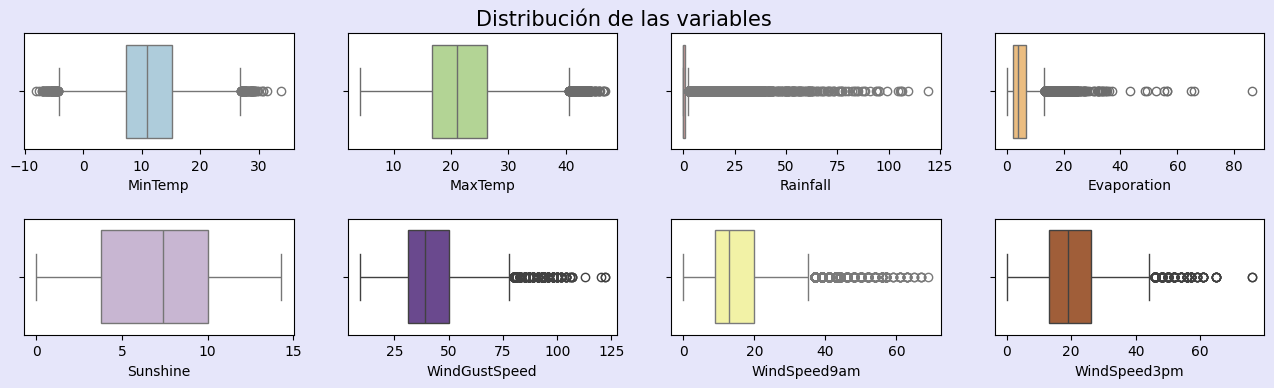

In [ ]:
# BOXPLOT DE LAS CARACTERÍSTICAS
box_plot(datos,0,8)

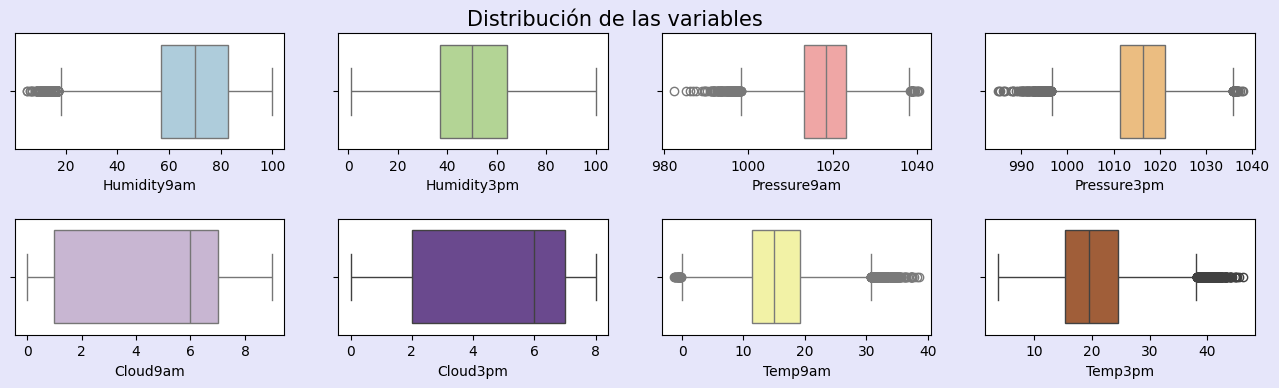

In [ ]:
box_plot(datos,8,-1)

**Como se puede ver, en la mayoría de las distribuciones se observan valores atípicos, pero esto puede deberse a que existen regiones climatológicas diferentes, lo que genera mediciones por debajo del mínimo o por encima del máximo registrado en la medición general.**

`No sería conveniente eliminar los valores atípicos porque se perderían tendencias reales.`

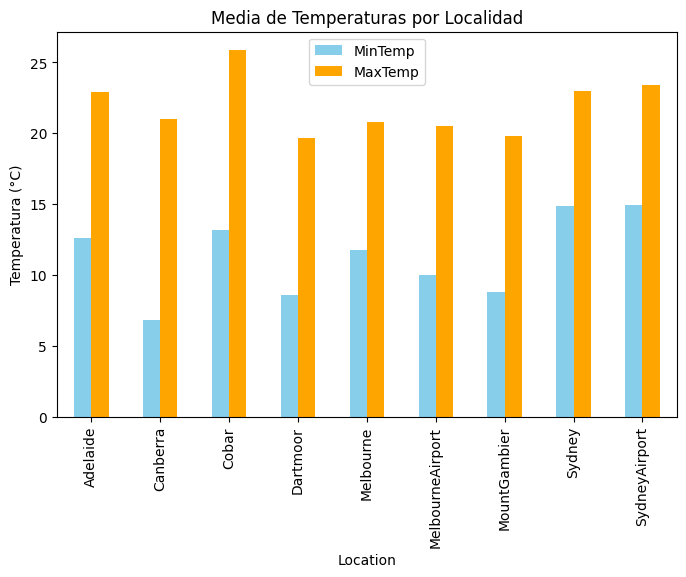

In [46]:
# DATOS POR LOCALIDAD AGRUPADOS Y CALCULO DE LA MEDIA DE CADA TEMPERATURA
medias_por_localidad = datos.groupby('Location').agg({'MinTemp': 'mean', 'MaxTemp': 'mean'})

medias_por_region = pd.DataFrame({'MinTemp': medias_por_localidad['MinTemp'], 'MaxTemp': medias_por_localidad['MaxTemp']})
medias_por_region.plot(kind='bar', figsize=(8, 5), color=['skyblue', 'orange'])

plt.ylabel('Temperatura (°C)')
plt.title('Media de Temperaturas por Localidad')
plt.legend(loc='upper center')
plt.show()

**Observación:**

*   **Las temperatura media máxima en las diferentes localidades se encuentra entr 20°C y 25°C.**
*   **Las temperatura media mínima en las diferentes localidades se encuentra entr 6°C y 15°C.**

## **Train test split**

**La división del set de datos en train y test toma en cuenta patrones estacionales, por lo que se decide no dividir aleatoriamente y tratar de conservarlos lo más que se pueda. Por lo tanto:**

*   **Se establece como límite el 31-10-2015 para acumular aproximadamente el 80% de los datos en train, de los cuáles un 12% de estos se utilizan para validación.**

*   **El 20% restante de los datos (desde el 01-11-2015 en adelante) se utilizan para testeo.**

In [35]:
# CALCULOS PARA ESTABLECER LIMITES DE SEPARACIÓN DEL SET DE DATOS
train_shape = (len(datos[datos.Date <= '2015-10-31'])/len(datos))*100
validation_shape = (len(datos[datos.Date.between('2015-01-01', '2015-10-31')])/len(datos[datos.Date <= '2015-10-31']))*100
print(f'Tamaño de train: {round(train_shape,)}%\nDe los cuales {round(validation_shape,)}% es para validación')

Tamaño de train: 81%
De los cuales 12% es para validación


In [36]:
# SPLIT Y VALIDACIÓN
x_train = datos[datos.Date <= '2014-12-31'].drop(['RainfallTomorrow','RainTomorrow'], axis=1).copy()
x_test = datos[datos.Date >= '2015-11-01'].drop(['RainfallTomorrow','RainTomorrow'], axis=1).copy()
y_train = datos[datos.Date <= '2014-12-31'].RainfallTomorrow.values.reshape(-1,1)
y_test = datos[datos.Date >= '2015-11-01'].RainfallTomorrow.values.reshape(-1,1)

x_val = datos[datos.Date.between('2015-01-01', '2015-10-31')].drop(['RainfallTomorrow','RainTomorrow'], axis=1).copy()
y_val = datos[datos.Date.between('2015-01-01', '2015-10-31')].RainfallTomorrow.values.reshape(-1,1)

# TAMAÑO DE LOS CONJUNTOS
print(f'Total de datos en train: {x_train.shape[0]}\nTotal de datos en test: {x_test.shape[0]}\nTotal de datos en validación: {x_val.shape[0]}')

Total de datos en train: 20079
Total de datos en test: 5418
Total de datos en validación: 2736


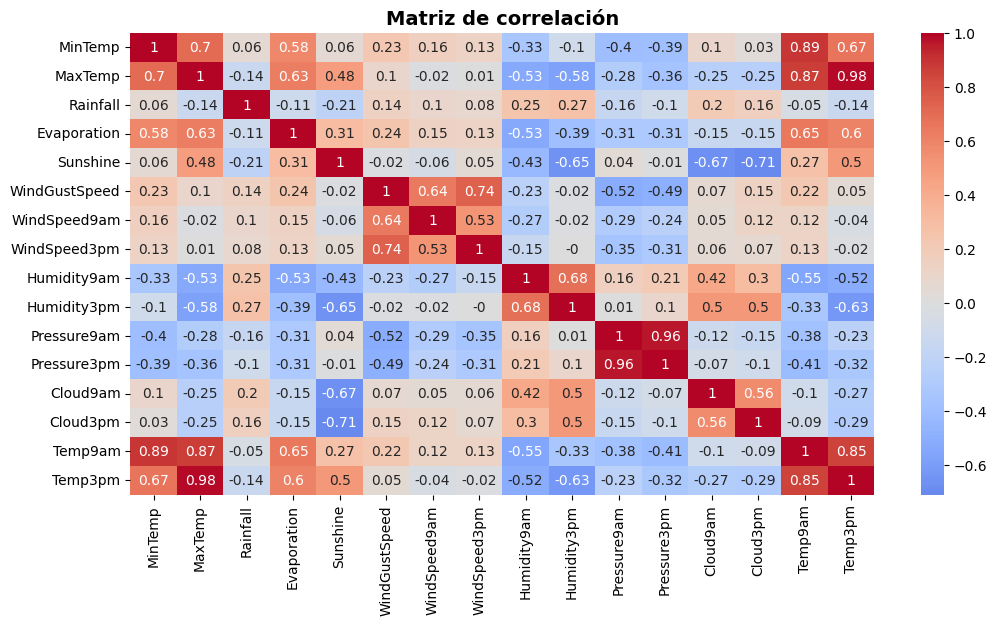

In [40]:
# MATRIZ DE CORRELACIÓN
warnings.filterwarnings("ignore", category=FutureWarning)
corr = x_train.select_dtypes(exclude=['object']).corr().round(2)
plt.figure(figsize=(12, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title('Matriz de correlación',fontweight='bold',fontsize=14)
plt.show()

**Del mapa de calor de correlación anterior, se puede concluir que:**

*   **Las variables MinTemp y MaxTemp están altamente correlacionadas positivamente (coeficiente de correlación = 0,7).**

*   **Las variables MinTemp y Temp3pm también tienen una correlación muy positiva (coeficiente de correlación = 0,67).**

*   **Las variables MinTemp y Temp9am están fuertemente correlacionadas positivamente (coeficiente de correlación = 0,89).**

*   **Las variables MaxTemp y Temp9am están fuertemente correlacionadas positivamente (coeficiente de correlación = 0,87).**

*   **Las variables MaxTemp y Temp3pm también están fuertemente correlacionadas positivamente (coeficiente de correlación = 0,98).**

*  **Las variables WindGustSpeed ​​y WindSpeed3pm están altamente correlacionadas positivamente (coeficiente de correlación = 0,74).**

*   **Las variables Presión9am y Presión3pm están fuertemente correlacionadas positivamente (coeficiente de correlación = 0,96).**

*   **Las variables Temp9am y Temp3pm están fuertemente correlacionadas positivamente (coeficiente de correlación = 0,85).**

### **Imputación de datos faltantes**

In [ ]:
# DATOS CATEGÓRICOS
variables_categoricas = ['WindGustDir','WindDir9am', 'WindDir3pm', 'RainToday']

for x in variables_categoricas: x_train[x].fillna(x_train[x].mode()[0], inplace = True)
for y in variables_categoricas: x_val[y].fillna(x_train[y].mode()[0], inplace = True)
for z in variables_categoricas: x_test[z].fillna(x_train[z].mode()[0], inplace = True)

In [ ]:
# DATOS NUMÉRICOS
variables_numericas = x_train.select_dtypes(exclude=['object']).columns.tolist()

for columna in variables_numericas:
  x_train[columna].fillna(x_train[columna].median(), inplace=True)
  x_test[columna].fillna(x_train[columna].median(), inplace=True)
  x_val[columna].fillna(x_train[columna].median(), inplace=True)

# MEDIANA DE y_train
mediana = np.nanmedian(y_train)

# VALORES NULOS EN y_train Y y_test CON LA MEDIANA
y_train = np.nan_to_num(y_train, nan=mediana)
y_test = np.nan_to_num(y_test, nan=mediana)
y_val = np.nan_to_num(y_val, nan=mediana)

**Notas:**

*   **Para tratar los datos faltantes en las variables categóricas, se los imputara con la moda. En el caso de las variables numéricas, se lo hara con la mediana, ya que suele ser una medida más robusta antes los valores atípicos.**

*   **Las medidas estadísticas que se utilizaron para completar los valores faltantes tanto en train, test y validación, se extraen únicamente del conjunto de train. Esto es para evitar un sobreajuste.**

### **Codificación de características**

In [ ]:
# CODIFICACIÓN DE LA COLUMNA 'Date' QUE ALMACENA LAS FECHAS
x_train['Date'] = pd.to_datetime(x_train['Date'], format='%Y-%m-%d')
x_train['Day'] = x_train['Date'].dt.day
x_train['Month'] = x_train['Date'].dt.month
x_train['Year'] = x_train['Date'].dt.year
x_train.drop('Date', axis=1, inplace=True)

x_test['Date'] = pd.to_datetime(x_test['Date'], format='%Y-%m-%d')
x_test['Day'] = x_test['Date'].dt.day
x_test['Month'] = x_test['Date'].dt.month
x_test['Year'] = x_test['Date'].dt.year
x_test.drop('Date', axis=1, inplace=True)

x_val['Date'] = pd.to_datetime(x_val['Date'], format='%Y-%m-%d')
x_val['Day'] = x_val['Date'].dt.day
x_val['Month'] = x_val['Date'].dt.month
x_val['Year'] = x_val['Date'].dt.year
x_val.drop('Date', axis=1, inplace=True)

"""# # BinaryEncoder PARA LAS DEMAS COLUMNAS CON VARIABLES CATEGÓRICAS
variables = x_train.select_dtypes(include=['object']).columns.tolist()
encoder = ce.BinaryEncoder(cols=variables)
x_train = encoder.fit_transform(x_train)
x_test = encoder.transform(x_test)
x_val =  encoder.transform(x_val)"""

x_train = pd.get_dummies(x_train)
x_test = pd.get_dummies(x_test)
x_val = pd.get_dummies(x_val)

**Para codificar la fecha, primero se convierte la columna 'Date' a datetime y se descompone en día, mes y año respectivamente. Estas nuevas columnas son de tipo int32.**

**En el caso de las demás variables categóricas, se utiliza una codificación One-Hot, ya que mejora muy ligeramente algunas métricas con respecto a otros codificadores que fueron probados, que reducen el número de columnas generadas a costo de perder algo de información.**

### **Estandarización**

In [ ]:
scaler = StandardScaler()
x_train_scaled=scaler.fit_transform(x_train)
x_test_scaled=scaler.transform(x_test)
x_val_scaled=scaler.transform(x_val)

**Se escalan los datos utilizando la estandarización, ya que se presentan datos en con escalas muy diferentes. De esta manera todas la características contribuiran de manera similar, y se mejora la robustez frente a valores atípicos.**

## **Modelo**

In [ ]:
lr_model = LinearRegression(fit_intercept=True)

lr_model.fit(x_train_scaled,y_train)

LinearRegression()

In [ ]:
# Pendiente e intercepto
lr_model.coef_, lr_model.intercept_

(array([[-4.54127843e-01,  5.06736939e-01,  7.14665118e-01,
          9.02282533e-02, -8.03418751e-01,  1.28491748e+00,
         -1.11818575e-03, -4.90713477e-01, -1.68394306e-01,
          2.34046515e+00,  2.33644432e+00, -2.88352314e+00,
         -1.46617424e-01,  1.96758936e-01, -1.83126793e-03,
          3.10278500e-01,  4.31574019e-02, -2.07196730e-02,
         -2.43965744e-02, -3.40181840e+12, -3.55354156e+12,
         -3.27886389e+12, -3.27886389e+12, -3.40181840e+12,
         -3.27886389e+12, -3.30010443e+12, -3.49743859e+12,
         -3.27886389e+12,  6.90882133e+12,  7.06298168e+12,
          6.89416463e+12,  1.50456978e+13,  7.19474237e+12,
          7.49467216e+12,  8.29901257e+12,  8.90670739e+12,
          1.04295572e+13,  7.17142012e+12,  9.32821821e+12,
          9.45888725e+12,  1.01514597e+13,  9.83399701e+12,
          8.59083012e+12,  9.57741482e+12,  1.55435863e+11,
          1.41393019e+11,  1.49768646e+11,  3.30961318e+11,
          1.71586824e+11,  1.97109815e+1

In [ ]:
# FUNCIÓN PARA OBTENER LAS MÉTRICAS DE LOS MODELOS
def metricas(x_train, x_test, y_train, y_test, y_pred, modelo):

  # COEFICIENTE DE REGRESIÓN
  r2_train, r2_test = modelo.score(x_train,y_train), modelo.score(x_test,y_test)

  # ERROR CUADRÁTICO MEDIO
  mse = mean_squared_error(y_test, y_pred)

  # RAÍZ DEL ERROR ABSOLUTO MEDIO
  rmse = mean_squared_error(y_test, y_pred, squared = False)

  # ERROR ABSOLUTO MEDIO
  mae = mean_absolute_error(y_test, y_pred)

  # ERROR PORCENTUAL ABSOLUTO MEDO
  # mape_lr = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

  print(f'\nEl R2 del test es: {r2_test.round(3)}\n')
  print(f'El R2 del entrenamiento es: {r2_train.round(3)}\n')
  print(f'El MSE es: {mse.round(2)}\n')
  print(f'El RMSE es: {rmse.round(2)}\n')
  print(f'El error MAE es: {mae.round(2)}\n')

In [ ]:
# PREDICCIONES REGRESIÓN LINEAL
y_pred_lr = lr_model.predict(x_test_scaled)

metricas(x_train_scaled, x_test_scaled, y_train, y_test, y_pred_lr, lr_model)


El R2 del test es: 0.252

El R2 del entrenamiento es: 0.223

El MSE es: 33.62

El RMSE es: 5.8

El error MAE es: 2.71



## **Gradiente descendiente**

In [ ]:
def gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100):
    """
    shapes:
        X_train = nxm
        y_train = nx1
        X_test = pxm
        y_test = px1
        W = mx1
    """
    n = X_train.shape[0]
    m = X_train.shape[1]

    o = X_test.shape[0]

    # Poner columna de unos a las matrices X
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((o, 1)), X_test))


    # Inicializar pesos aleatorios
    W = np.random.randn(m+1).reshape(m+1, 1)

    train_errors = []  # Para almacenar el error de entrenamiento en cada época
    test_errors = []   # Para almacenar el error de prueba en cada época

    for i in range(epochs):
        # Calcular predicción y error de entrenamiento
        prediction_train = np.matmul(X_train, W)
        error_train = y_train - prediction_train
        #print(error_train)
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # Calcular predicción y error de prueba
        prediction_test = np.matmul(X_test, W)
        error_test = y_test - prediction_test
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)

        # Calcular el gradiente y actualizar pesos
        grad_sum = np.sum(error_train * X_train, axis=0)
        grad_mul = -2/n * grad_sum  # 1xm
        gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1

        W = W - (lr * gradient)

    # Graficar errores de entrenamiento y prueba
    # Definir una figura
    plt.figure(figsize=(12, 6))
    # Plotear errores de entrenamiento
    plt.plot(train_errors, label='Error de entrenamiento')
    # Plotear errores de prueba
    plt.plot(test_errors, label='Error de test')
    # Poner labels en los ejes
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    # Activar la leyenda
    plt.legend()
    # Poner titulo
    plt.title('Error de entrenamiento y prueba vs iteraciones (GD)')
    # Terminar y mostrar gráfico
    plt.show()

    return train_errors[-1], test_errors[-1]

In [ ]:
def stochastic_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100):

    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):
        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]

        for j in range(n):
            # Obtener una muestra aleatoria de un solo dato para hacer SGD
            x_sample = X_train[j]
            y_sample = y_train[j][0]

            prediction = np.matmul(x_sample, W)
            error = y_sample - prediction
            train_mse = error ** 2
            train_errors.append(train_mse)

            gradient = -2 * error * x_sample.T.reshape(-1, 1)

            W = W - (lr * gradient)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (SGD)')
    plt.show()

    return W

In [ ]:
def mini_batch_gd(X_train, y_train, X_test, y_test, lr=0.01, epochs=100, batch_size=11):
    n, m = X_train.shape[0], X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors, test_errors = [], []

    for i in range(epochs):

        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]


        for j in range(0, n, batch_size):
            # Obtener un lote (mini-batch) de datos
            x_batch = X_train[j:j+batch_size, :]
            y_batch = y_train[j:j+batch_size].reshape(-1, 1)

            prediction = np.matmul(x_batch, W)
            error = y_batch - prediction
            train_mse = np.mean(error ** 2)
            train_errors.append(train_mse)

            gradient = -2 * np.matmul(x_batch.T, error) / batch_size

            W = W - (lr * gradient)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

    plt.figure(figsize=(5, 4))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (Mini-Batch GD)')
    plt.show()

    return W

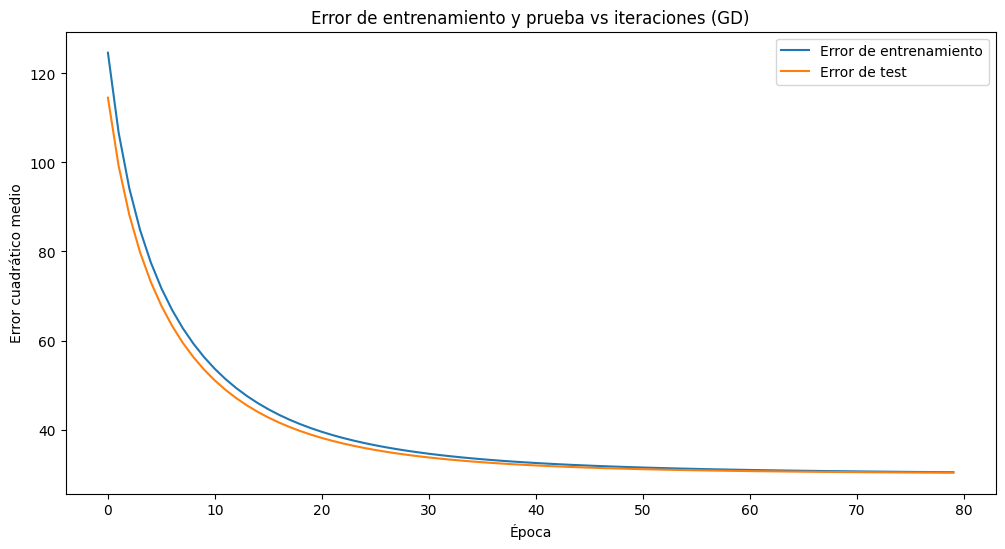

In [ ]:
# GRADIENTE DESCENDIENTE
gd = gradient_descent(x_train_scaled, y_train, x_val_scaled, y_val, lr=0.03, epochs=80)

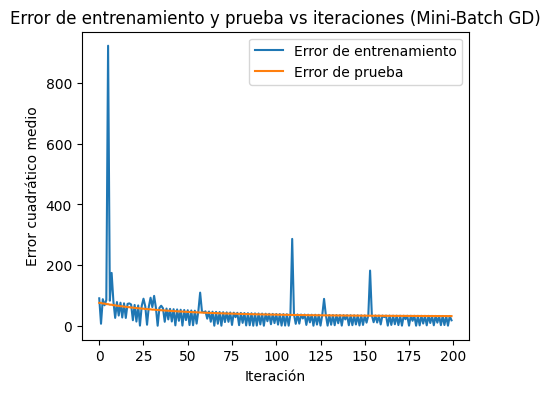

In [ ]:
# GRADIENTE DESCENDIENTE ESTOCÁSTICO
sgd = mini_batch_gd(x_train_scaled, y_train, x_val_scaled, y_val, lr=0.01, epochs=100, batch_size=(len(x_train_scaled) -1))

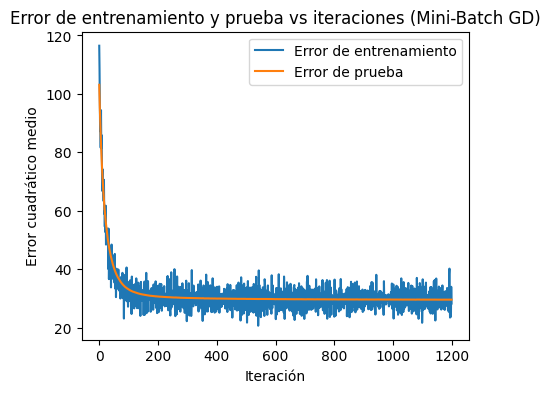

In [ ]:
# GRADIENTE DESCENDIENTE MINI BATCH
mbgd = mini_batch_gd(x_train_scaled, y_train, x_val_scaled, y_val, lr=0.01, epochs=300, batch_size=5096)

## **Regularización**

### **Ridge**

In [ ]:
r_model = RidgeCV(alphas = np.logspace(-10, 10, 200),
                 fit_intercept   = True,
                 store_cv_values = True)

r_model.fit(x_train_scaled, y_train)

RidgeCV(alphas=array([1.00000000e-10, 1.26038293e-10, 1.58856513e-10, 2.00220037e-10,
       2.52353917e-10, 3.18062569e-10, 4.00880633e-10, 5.05263107e-10,
       6.36824994e-10, 8.02643352e-10, 1.01163798e-09, 1.27505124e-09,
       1.60705282e-09, 2.02550194e-09, 2.55290807e-09, 3.21764175e-09,
       4.05546074e-09, 5.11143348e-09, 6.44236351e-09, 8.11984499e-09,
       1.02341140e-08, 1.28989026e-0...
       4.88025158e+07, 6.15098579e+07, 7.75259749e+07, 9.77124154e+07,
       1.23155060e+08, 1.55222536e+08, 1.95639834e+08, 2.46581108e+08,
       3.10786619e+08, 3.91710149e+08, 4.93704785e+08, 6.22257084e+08,
       7.84282206e+08, 9.88495905e+08, 1.24588336e+09, 1.57029012e+09,
       1.97916687e+09, 2.49450814e+09, 3.14403547e+09, 3.96268864e+09,
       4.99450512e+09, 6.29498899e+09, 7.93409667e+09, 1.00000000e+10]),
        store_cv_values=True)

In [ ]:
# PREDICCIONES RIDGE
y_pred_r = r_model.predict(x_test_scaled)

metricas(x_train_scaled, x_test_scaled, y_train, y_test, y_pred_r, r_model)


El R2 del test es: 0.252

El R2 del entrenamiento es: 0.223

El MSE es: 33.63

El RMSE es: 5.8

El error MAE es: 2.7



### **Lasso**

In [ ]:
l_model = LassoCV(alphas=np.logspace(-10, 10, 200),cv=10)

_ = l_model.fit(x_train_scaled, y_train.ravel())

In [ ]:
# PREDICCIONES LASSO
y_pred_l = l_model.predict(x_test_scaled)

metricas(x_train_scaled, x_test_scaled, y_train, y_test, y_pred_l, l_model)


El R2 del test es: 0.25

El R2 del entrenamiento es: 0.222

El MSE es: 33.72

El RMSE es: 5.81

El error MAE es: 2.69



### **ElasticNet**

In [ ]:
e_model = ElasticNetCV(l1_ratio = [0, 0.01, 0.05, 0.9, 0.35, 0.40],
                      alphas = np.logspace(-5, 10, 200),
                      cv = 5)

_ = e_model.fit(x_train_scaled, y_train)

In [ ]:
# PREDICCIONES ELASTICNET
y_pred_e = e_model.predict(x_test_scaled)

metricas(x_train_scaled, x_test_scaled, y_train, y_test, y_pred_e, e_model)


El R2 del test es: 0.252

El R2 del entrenamiento es: 0.223

El MSE es: 33.62

El RMSE es: 5.8

El error MAE es: 2.7



## **Métricas**
**Comparación entre modelos**

In [ ]:
# NOMBRE DE LOS MODELOS
modelos = ['LR', 'RIDGE', 'LASSO', 'ELASTIC NET']

# MÉTRICAS CALCULADAS
metricas = ['R2_TRAIN', 'R2_TEST', 'MSE', 'RMSE', 'MAE']

# DATAFRAME
cuadro_metricas = pd.DataFrame(index=metricas, columns=modelos)

valores = [
    [lr_model.score(x_train_scaled,y_train).round(3),
     r_model.score(x_train_scaled,y_train).round(3),
     l_model.score(x_train_scaled,y_train).round(3),
     e_model.score(x_train_scaled,y_train).round(3)],
    [lr_model.score(x_test_scaled,y_test).round(3),
     r_model.score(x_test_scaled,y_test).round(3),
     l_model.score(x_test_scaled,y_test).round(3),
     e_model.score(x_test_scaled,y_test).round(3)],
    [mean_squared_error(y_test, y_pred_lr).round(3),
     mean_squared_error(y_test, y_pred_r).round(3),
     mean_squared_error(y_test, y_pred_l).round(3),
     mean_squared_error(y_test, y_pred_e).round(3)],
    [mean_squared_error(y_test, y_pred_lr, squared = False).round(3),
     mean_squared_error(y_test, y_pred_r, squared = False).round(3),
     mean_squared_error(y_test, y_pred_l, squared = False).round(3),
     mean_squared_error(y_test, y_pred_e, squared = False).round(3)],
    [mean_absolute_error(y_test, y_pred_lr).round(3),
     mean_absolute_error(y_test, y_pred_r).round(3),
     mean_absolute_error(y_test, y_pred_lr).round(3),
     mean_absolute_error(y_test, y_pred_e).round(3)]
]

for i, metrica in enumerate(metricas):
    cuadro_metricas.loc[metrica] = valores[i]

In [ ]:
# COMPARACIÓN DE LAS MÉTRICAS EN LOS DIFERENTES MODELOS

             LR   RIDGE   LASSO ELASTIC NET
R2_TRAIN  0.223   0.223   0.222       0.223
R2_TEST   0.252   0.252    0.25       0.252
MSE       33.62  33.633  33.716      33.619
RMSE      5.798   5.799   5.807       5.798
MAE       2.707   2.702   2.707       2.704


**Como se puede oservar en el cuadro de arriba, la variación de las métricas calculadas es infima, por lo que los modelos están proporcionando resultados bastante similares en términos de ajuste y precisión en la predicción.**

## **Intepretación**

**Los resultados obtenidos muestran que los modelos de regresión lineal, incluyendo Ridge, Lasso y Elastic Net, no logran capturar de manera efectiva la variabilidad presente en el conjunto de datos, como lo indica el bajo coeficiente de determinación (R2). Con un R2 aproximadamente del 25%, se estima que solo alrededor del 25% de la variabilidad en la variable objetivo es explicada por estos modelos, lo que sugiere que la regresión lineal podría no ser la mejor opción para este problema en particular.**